# House and Appartement pricing in Haute_Garonne (31)

The goal is to fecth data from data.gouv.fr of the house sell in the department 31 for finding some patterns and deploy a model to predict the value of an house or appartment.
* Source : https://files.data.gouv.fr/geo-dvf/latest/csv/  
---
The notebook is separated like that : \
1 - Necessary importation  
2 - Recuperation of all the datas (.csv) for 2022 and 2023 and combined in one dataframe    
3 - Simplification and cleaning of the datas (dropped unnecessary columns, filled missing datas, convert data for ML)  
4 - Analysis for Outliers determination  
5 - Rapid exploratoring  
  
6 - Model

---

## Importation

In [1]:
import os
import uuid
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

## Data collection

### Fetch the datas, downloading and stored in one folder

In [106]:
def get_csv(url,download_folder) : 
    response = requests.get(url)
    response.raise_for_status()
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    csv_links = soup.find_all('a', href=True)
    csv_links = [link for link in csv_links if link['href'].endswith('.csv')]
    
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
              
    for link in csv_links:
        file_url = urljoin(url, link['href'])
        original_file_name = os.path.basename(link['href'])
        unique_file_name = f"{uuid.uuid4()}_{original_file_name}"
        file_path = os.path.join(download_folder, unique_file_name)
        
        try :    
            file_response = requests.get(file_url)
            file_response.raise_for_status()
    
            with open(file_path, 'wb') as file:
                file.write(file_response.content)
        except requests.exceptions.RequestException as e:
            print(f'Error downloading {unique_file_name}:{e}')
    
    print('Download completed for URL:'url)   

In [5]:
# Folder location
download_folder = r'C:\Users\melan\Desktop\DeveloppementInfo\Portfolio\ProjectsData\House_Price_Toulouse\CSV'

In [110]:
# urls 
urls = ['https://files.data.gouv.fr/geo-dvf/latest/csv/2023/communes/31/',
    'https://files.data.gouv.fr/geo-dvf/latest/csv/2022/communes/31/']

In [112]:
for url in urls:
    get_csv(url, download_folder)

Téléchargement terminé pour URL:. https://files.data.gouv.fr/geo-dvf/latest/csv/2023/communes/31/
Téléchargement terminé pour URL:. https://files.data.gouv.fr/geo-dvf/latest/csv/2022/communes/31/


### Concatenation of all the data in one csv file

In [114]:
dfs = []
for file_name in os.listdir(download_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(download_folder, file_name)
        # Lire chaque fichier CSV et l'ajouter à la liste des DataFrames
        df = pd.read_csv(file_path)
        dfs.append(df)
        
concatenated_df = pd.concat(dfs, ignore_index=True)
output_file = os.path.join(download_folder, 'concatenated.csv')
concatenated_df.to_csv(output_file, index=False)

print(f'All CSV files have been concatenated into : {output_file}')

Tous les fichiers CSV ont été concaténés en : C:\Users\melan\Desktop\DeveloppementInfo\Portfolio\ProjectsData\House_Price_Toulouse\CSV\concatenated.csv


## Cleaning

### Reading CSV concatenated

In [43]:
df = pd.read_csv(os.path.join(download_folder, 'concatenated.csv'))

In [9]:
df.head(3)

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2022-450002,2022-01-13,1,Vente,315000.0,67.0,NaN,CHE LE CARRETAL,0026,31790.0,...,Maison,125.0,5.0,S,sols,NaN,NaN,482.0,1.400431,43.750158
1,2022-450002,2022-01-13,1,Vente,315000.0,NaN,NaN,LE VILLAGE,B028,31790.0,...,NaN,NaN,NaN,S,sols,NaN,NaN,54.0,1.400366,43.750246
2,2022-451293,2022-02-01,1,Vente,217477.8,NaN,NaN,BORDENEUVE,B002,31790.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,194480.0,1.388276,43.736761


### Cleaning the number of lines

I am only interested in houses, apartments which are sold "normally" (not at auction, or "sold as is", ...).

In [45]:
df = df[(df.type_local=="Maison")|(df.type_local=="Appartement")].reset_index()

In [47]:
df = df[df.nature_mutation=='Vente']

In [49]:
df = df.drop_duplicates(subset=['id_mutation'])

In [37]:
len(df)

43199

### Cleaning features

In [51]:
df = df[['date_mutation','valeur_fonciere','code_postal','nom_commune','type_local','surface_reelle_bati','nombre_pieces_principales','nature_culture','surface_terrain']]

In [53]:
df = df.reset_index(drop=True)

In [55]:
df

,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain
0,2022-01-13,315000.0,31790.0,Saint-Sauveur,Maison,125.0,5.0,sols,482.0
1,2022-03-23,409670.0,31790.0,Saint-Sauveur,Maison,160.0,4.0,sols,1161.0
2,2022-04-26,357350.0,31790.0,Saint-Sauveur,Maison,158.0,6.0,sols,1095.0
3,2022-05-09,353300.0,31790.0,Saint-Sauveur,Maison,114.0,5.0,sols,862.0
4,2022-05-11,500000.0,31790.0,Saint-Sauveur,Maison,255.0,5.0,sols,1200.0
...,...,...,...,...,...,...,...,...,...
43194,2022-12-27,98000.0,31600.0,Eaunes,Appartement,37.0,2.0,NaN,NaN
43195,2023-04-04,70000.0,31260.0,Escoulis,Maison,67.0,3.0,sols,60.0
43196,2023-08-01,240000.0,31260.0,Escoulis,Maison,120.0,4.0,terrains d'agrément,5345.0
43197,2023-09-29,121720.0,31260.0,Escoulis,Maison,78.0,3.0,sols,488.0


### date_mutation

In [58]:
df.date_mutation = pd.to_datetime(df.date_mutation)

In [60]:
df['year'] = df['date_mutation'].dt.year

In [63]:
df = df.drop('date_mutation',axis=1)

### code_postal

In [66]:
df['code_postal'] = df['code_postal'].apply(str)
df['code_postal'] = df['code_postal'].str.split('.').str[0]

### Missing data

In [70]:
def percent_missing(df):
    per_nan = 100*df.isnull().sum() /len(df)
    per_nan = per_nan[per_nan >0].sort_values()
    
    return per_nan

In [72]:
per_nan = percent_missing(df)
per_nan

surface_reelle_bati           0.002315
nombre_pieces_principales     0.002315
valeur_fonciere               0.062501
nature_culture               56.408713
surface_terrain              56.408713
dtype: float64

In [74]:
df = df.dropna(subset=['valeur_fonciere','surface_reelle_bati','nombre_pieces_principales'])

In [76]:
df['nature_culture'] = df['nature_culture'].fillna('None')
df['surface_terrain'] = df['surface_terrain'].fillna(0)

In [78]:
per_nan = percent_missing(df)
per_nan

Series([], dtype: float64)

## Save the clean data, separated House and Apartement (Appt)

In [80]:
#save version df final
df.to_csv("HouseApptPrice_Tls.csv",index=False)

In [83]:
df = pd.read_csv("HouseApptPrice_Tls.csv")

In [86]:
# Separate apartment and house
df_maison = df[df['type_local']=='Maison']
df_appt = df[df['type_local']=='Appartement']

In [88]:
df_maison.to_csv("HousePrice_Tls.csv",index=False)
df_appt.to_csv("ApptPrice_Tls.csv",index=False)

In [90]:
len(df_maison)

19426

In [92]:
len(df_appt)

23745

## Analysis for outliers determination

### Analysis

In [554]:
df_house = pd.read_csv("HousePrice_Tls.csv")

In [556]:
# average price,for a houe, per m² (May 2024) Hautegaronne 2 803euros
df_house['prix_mcarre'] = df_house['valeur_fonciere']/df_house['surface_reelle_bati']

In [558]:
df_house['valeur_fonciere'].describe()

count    1.942600e+04
mean     3.171762e+05
std      2.513668e+05
min      1.000000e+00
25%      1.970000e+05
50%      2.805850e+05
75%      3.818928e+05
max      1.392000e+07
Name: valeur_fonciere, dtype: float64

In [560]:
df_house['prix_mcarre'].describe()

count     19426.000000
mean       3034.996389
std        2637.410487
min           0.006452
25%        2096.022954
50%        2857.142857
75%        3541.239455
max      163764.705882
Name: prix_mcarre, dtype: float64

C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


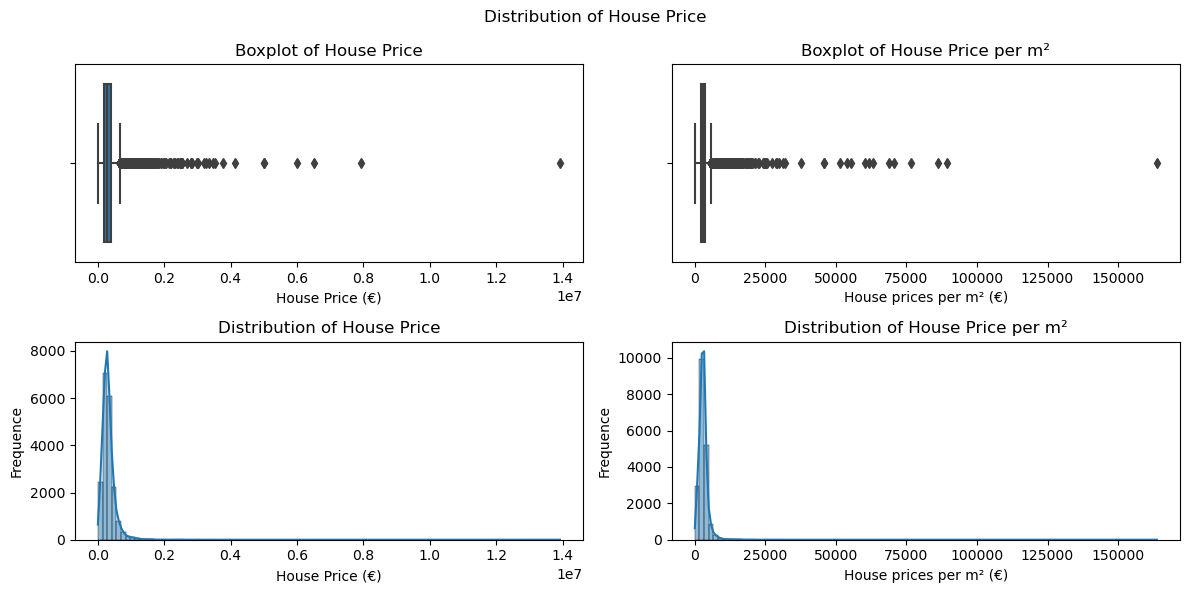

In [562]:
fig, axes = plt.subplots(2,2,figsize=(12, 6))

sns.boxplot(x=df_house['valeur_fonciere'], ax=axes[0][0])
axes[0][0].set_xlabel('House Price (€)')
axes[0][0].set_title('Boxplot of House Price')


sns.boxplot(x=df_house['prix_mcarre'], ax=axes[0][1])
axes[0][1].set_xlabel('House prices per m² (€)')
axes[0][1].set_title('Boxplot of House Price per m²')


sns.histplot(df_house['valeur_fonciere'], bins=100, kde=True,ax=axes[1][0])
axes[1][0].set_xlabel('House Price (€)')
axes[1][0].set_ylabel('Frequence')
axes[1][0].set_title('Distribution of House Price')


sns.histplot(df_house['prix_mcarre'], bins=100, kde=True,ax=axes[1][1])
axes[1][1].set_xlabel('House prices per m² (€)')
axes[1][1].set_ylabel('Frequence')
axes[1][1].set_title('Distribution of House Price per m²')


fig.suptitle('Distribution of House Price')  
plt.tight_layout()
plt.show()

In [564]:
df_house.sort_values('prix_mcarre',ascending=False).iloc[0]

valeur_fonciere                 13920000.0
code_postal                          31200
nom_commune                       Toulouse
type_local                          Maison
surface_reelle_bati                   85.0
nombre_pieces_principales              3.0
nature_culture                        sols
surface_terrain                      308.0
year                                  2022
prix_mcarre                  163764.705882
Name: 12229, dtype: object

### Outliers superior

In [566]:
def find_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3-q1
    outliers=df[((df<(q1-1.5*IQR)) | (df>(q3 + 1.5*IQR)))]
    return outliers   

In [568]:
outliers_valeur_fonciere = pd.DataFrame(find_outliers(df_house['valeur_fonciere']))
outliers_prix_mcarre = pd.DataFrame(find_outliers(df_house['prix_mcarre']))

In [570]:
index_outliers_valeur_fonciere = outliers_valeur_fonciere.index
index_outliers_prix_mcarre = outliers_prix_mcarre.index

In [572]:
drop_indices = index_outliers_valeur_fonciere.union(index_outliers_prix_mcarre)

In [574]:
len(drop_indices)

1340

In [576]:
100*len(drop_indices)/len(df_house)

6.897971790384021

In [578]:
df_house_cleaned = df_house.drop(index=drop_indices)

C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


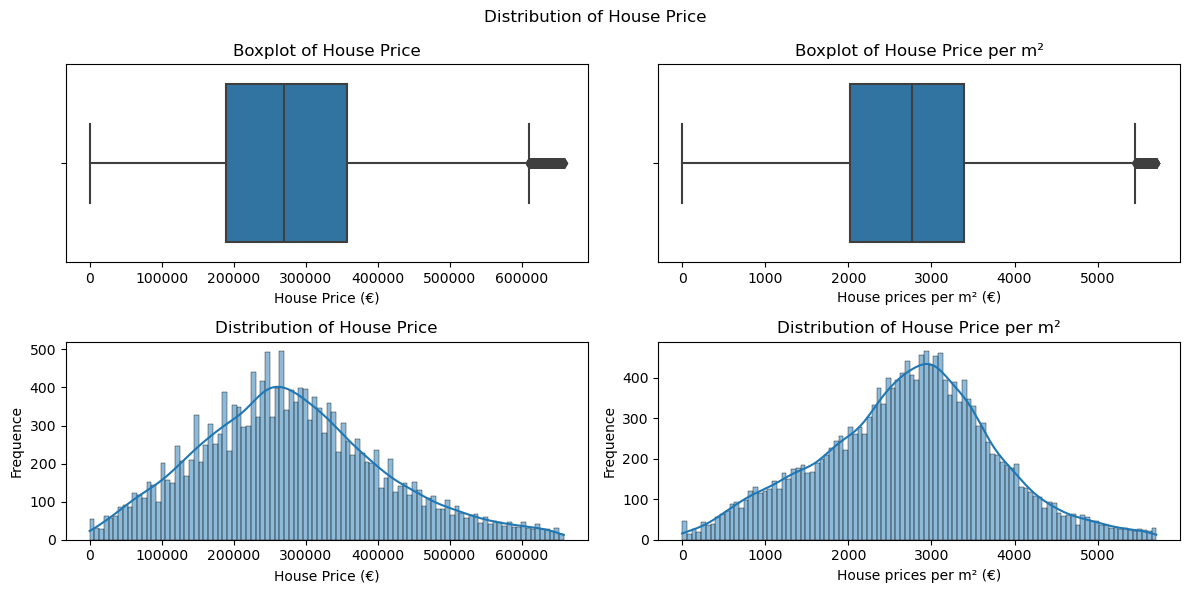

In [580]:
fig, axes = plt.subplots(2,2,figsize=(12, 6))

sns.boxplot(x=df_house_cleaned['valeur_fonciere'], ax=axes[0][0])
axes[0][0].set_xlabel('House Price (€)')
axes[0][0].set_title('Boxplot of House Price')


sns.boxplot(x=df_house_cleaned['prix_mcarre'], ax=axes[0][1])
axes[0][1].set_xlabel('House prices per m² (€)')
axes[0][1].set_title('Boxplot of House Price per m²')


sns.histplot(df_house_cleaned['valeur_fonciere'], bins=100, kde=True,ax=axes[1][0])
axes[1][0].set_xlabel('House Price (€)')
axes[1][0].set_ylabel('Frequence')
axes[1][0].set_title('Distribution of House Price')


sns.histplot(df_house_cleaned['prix_mcarre'], bins=100, kde=True,ax=axes[1][1])
axes[1][1].set_xlabel('House prices per m² (€)')
axes[1][1].set_ylabel('Frequence')
axes[1][1].set_title('Distribution of House Price per m²')


fig.suptitle('Distribution of House Price')  
plt.tight_layout()
plt.show()

### Outliers inferior

In [582]:
count_below_10000 = len(df_house_cleaned[df_house_cleaned['valeur_fonciere'] < 10000])
print(f"Nombre de ventes inférieures à 10 000 €: {count_below_10000}")

Nombre de ventes inférieures à 10 000 €: 61


C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


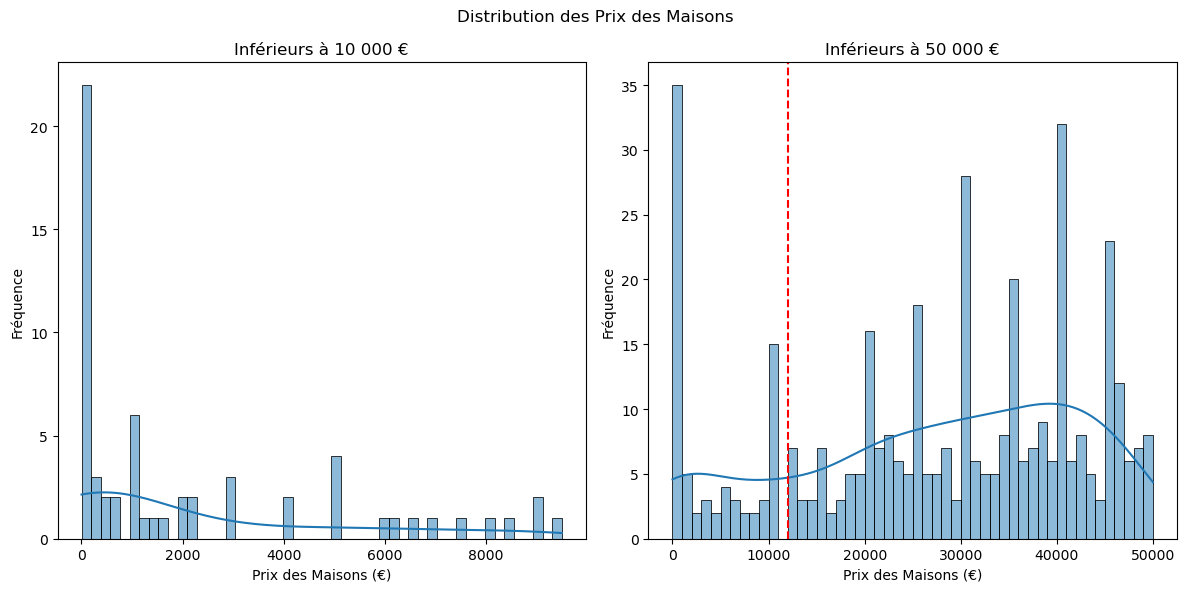

In [584]:
fig, axes = plt.subplots(1,2,figsize=(12, 6))

sns.histplot(df_house_cleaned[df_house_cleaned['valeur_fonciere'] < 10000]['valeur_fonciere'], bins=50, kde=True,ax=axes[0])
sns.histplot(df_house_cleaned[df_house_cleaned['valeur_fonciere'] < 50000]['valeur_fonciere'], bins=50, kde=True,ax=axes[1])

for axe in axes.flat :
    axe.set(xlabel='Prix des Maisons (€)',ylabel='Fréquence')
    axe.set_ylabel('Fréquence')

fig.suptitle('Distribution des Prix des Maisons')  

axes[0].set_title('Inférieurs à 10 000 €')
axes[1].set_title('Inférieurs à 50 000 €')
axes[1].axvline(x=12000,color='red',linestyle='--')
  
plt.tight_layout()

In [586]:
# La maison la moins chere trouvé : aubusson : milieu diagonal du vide : 490euros/m² ... bengalow en camping 409euros/metre carré (et pas au bord de la mer)!
df_house_cleaned[df_house_cleaned['prix_mcarre'] < 500]['prix_mcarre'].describe()

count    321.000000
mean     277.516164
std      156.283360
min        0.006452
25%      156.250000
50%      307.142857
75%      411.500000
max      497.537313
Name: prix_mcarre, dtype: float64

In [588]:
df_house_cleaned[df_house_cleaned['valeur_fonciere'] < 10000]['prix_mcarre'].describe()

count     61.000000
mean      51.387809
std      125.718650
min        0.006452
25%        0.013333
50%       10.000000
75%       50.000000
max      692.307692
Name: prix_mcarre, dtype: float64

C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


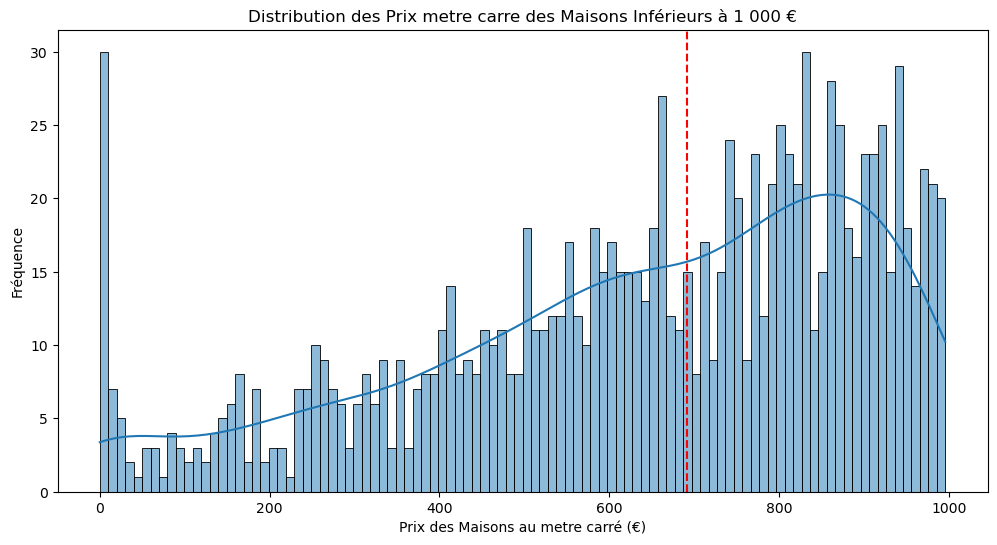

In [590]:
# La maison la moins chere trouvé : aubusson : milieu diagonal du vide : 490euros/m² 
plt.figure(figsize=(12, 6))
sns.histplot(df_house_cleaned[df_house_cleaned['prix_mcarre'] < 1000]['prix_mcarre'], bins=100, kde=True)
plt.title('Distribution des Prix metre carre des Maisons Inférieurs à 1 000 €')
plt.xlabel('Prix des Maisons au metre carré (€)')
plt.ylabel('Fréquence')
plt.axvline(x=692,color='red',linestyle='--')
plt.show()

In [592]:
df_house_cleaned = df_house_cleaned[df_house_cleaned['valeur_fonciere'] > 10000]

### Dataframe cleaned of value outliers

C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


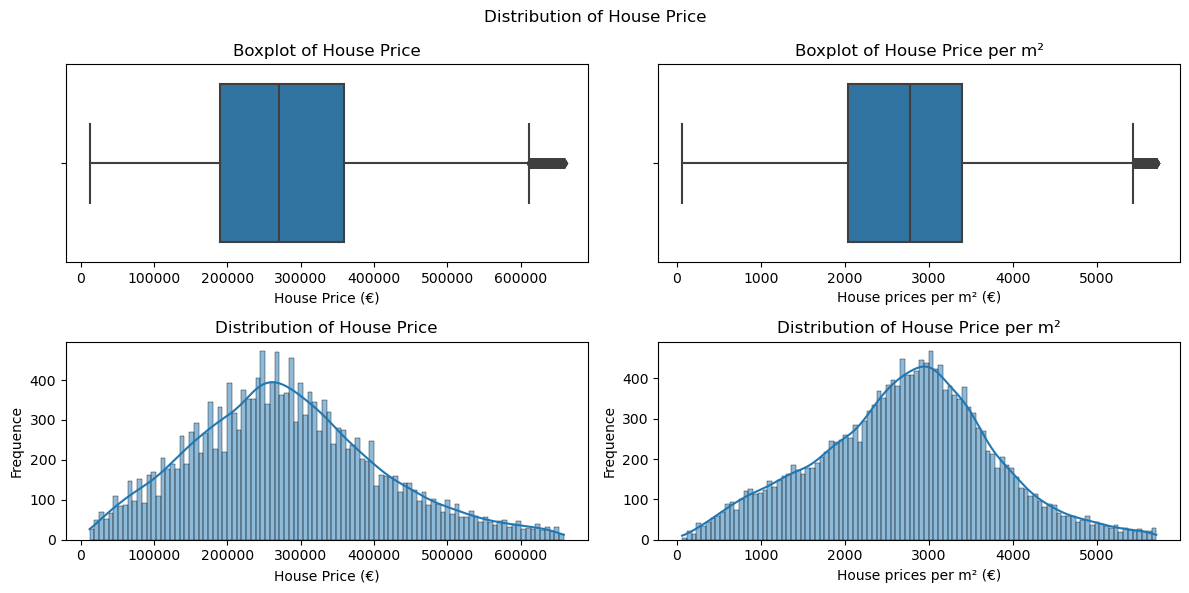

In [594]:
fig, axes = plt.subplots(2,2,figsize=(12, 6))

sns.boxplot(x=df_house_cleaned['valeur_fonciere'], ax=axes[0][0])
axes[0][0].set_xlabel('House Price (€)')
axes[0][0].set_title('Boxplot of House Price')


sns.boxplot(x=df_house_cleaned['prix_mcarre'], ax=axes[0][1])
axes[0][1].set_xlabel('House prices per m² (€)')
axes[0][1].set_title('Boxplot of House Price per m²')


sns.histplot(df_house_cleaned['valeur_fonciere'], bins=100, kde=True,ax=axes[1][0])
axes[1][0].set_xlabel('House Price (€)')
axes[1][0].set_ylabel('Frequence')
axes[1][0].set_title('Distribution of House Price')


sns.histplot(df_house_cleaned['prix_mcarre'], bins=100, kde=True,ax=axes[1][1])
axes[1][1].set_xlabel('House prices per m² (€)')
axes[1][1].set_ylabel('Frequence')
axes[1][1].set_title('Distribution of House Price per m²')


fig.suptitle('Distribution of House Price')  
plt.tight_layout()
plt.show()

### Outliers observed in others features

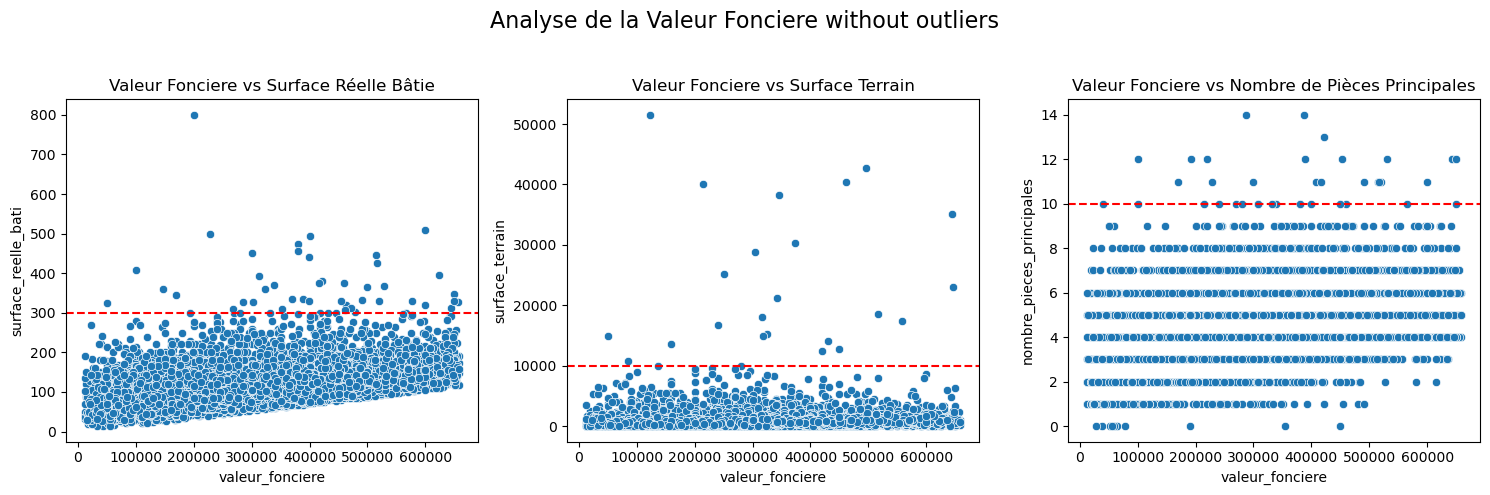

In [596]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='surface_reelle_bati', ax=axes[0])
axes[0].set_title('Valeur Fonciere vs Surface Réelle Bâtie')
axes[0].axhline(y=300,color='red', linestyle='--')

sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='surface_terrain', ax=axes[1])
axes[1].set_title('Valeur Fonciere vs Surface Terrain')
axes[1].axhline(y=10000,color='red', linestyle='--')

sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='nombre_pieces_principales', ax=axes[2])
axes[2].set_title('Valeur Fonciere vs Nombre de Pièces Principales')
axes[2].axhline(y=10,color='red', linestyle='--')

fig.suptitle('Analyse de la Valeur Fonciere without outliers', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [598]:
drop_ind_bati = df_house_cleaned[(df_house_cleaned['surface_reelle_bati']>300)].index
drop_ind_terrain = df_house_cleaned[(df_house_cleaned['surface_terrain']>10000)].index
drop_ind_piece = df_house_cleaned[(df_house_cleaned['nombre_pieces_principales']>10)].index

drop_indices = drop_ind_bati.union(drop_ind_terrain).union(drop_ind_piece)

df_house_cleaned = df_house_cleaned.drop(drop_indices,axis=0)

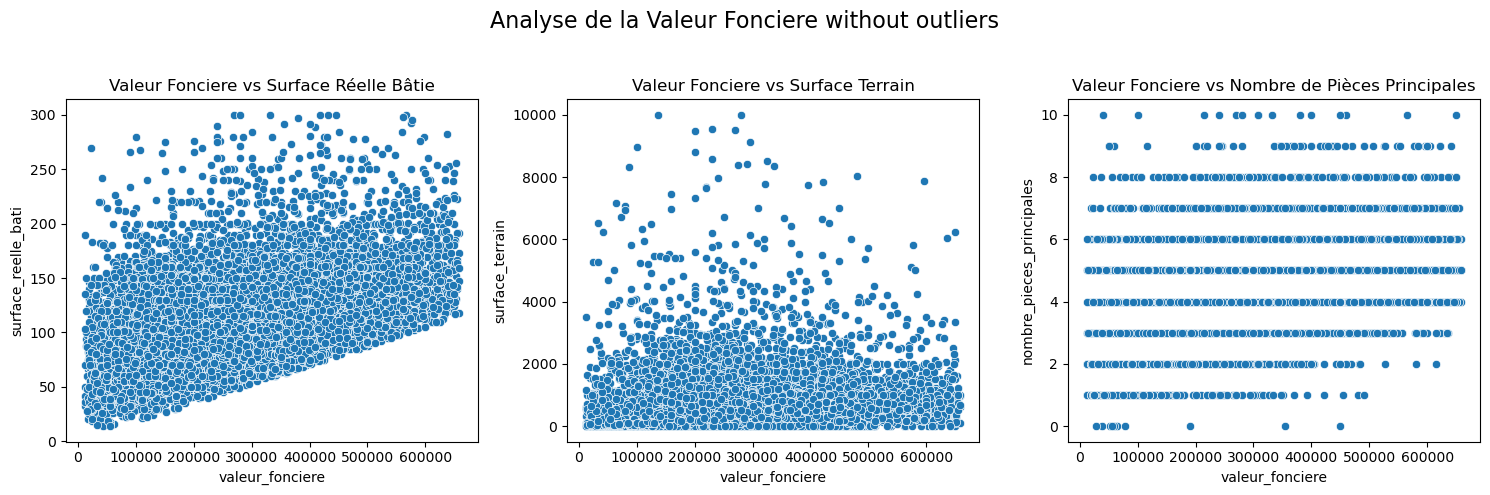

In [600]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='surface_reelle_bati', ax=axes[0])
axes[0].set_title('Valeur Fonciere vs Surface Réelle Bâtie')


sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='surface_terrain', ax=axes[1])
axes[1].set_title('Valeur Fonciere vs Surface Terrain')


sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='nombre_pieces_principales', ax=axes[2])
axes[2].set_title('Valeur Fonciere vs Nombre de Pièces Principales')


fig.suptitle('Analyse de la Valeur Fonciere without outliers', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [602]:
df_house_cleaned = df_house_cleaned.reset_index(drop=True)

In [604]:
df_house_cleaned.to_csv('HousePrice_Tls_cleaned.csv',index=False)

## Method 2 : logarithm distribution

In [151]:
df_house['log_valeur_fonciere'] = np.log1p(df_house['valeur_fonciere'])

C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


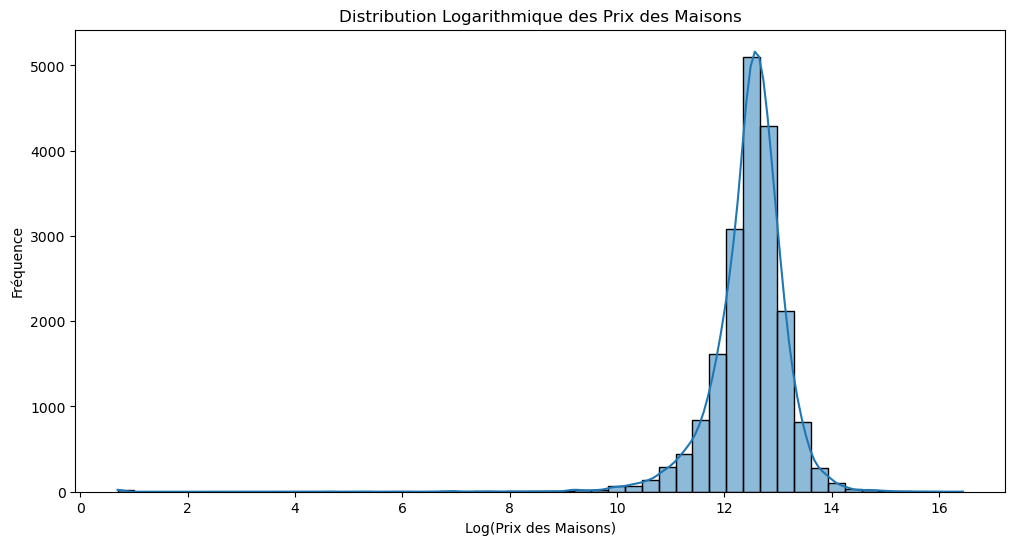

In [153]:
plt.figure(figsize=(12, 6))
sns.histplot(df_house['log_valeur_fonciere'], bins=50, kde=True)
plt.title('Distribution Logarithmique des Prix des Maisons')
plt.xlabel('Log(Prix des Maisons)')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
#df_house.to_csv('log_house_price.csv',index=False)

## EDA

In [606]:
df_house_cleaned = pd.read_csv('HousePrice_Tls_cleaned.csv')

In [608]:
df_house_cleaned['valeur_fonciere'].describe()

count     17934.000000
mean     280214.345446
std      127168.786611
min       12000.000000
25%      190000.000000
50%      270040.000000
75%      357697.500000
max      658700.000000
Name: valeur_fonciere, dtype: float64

### Year

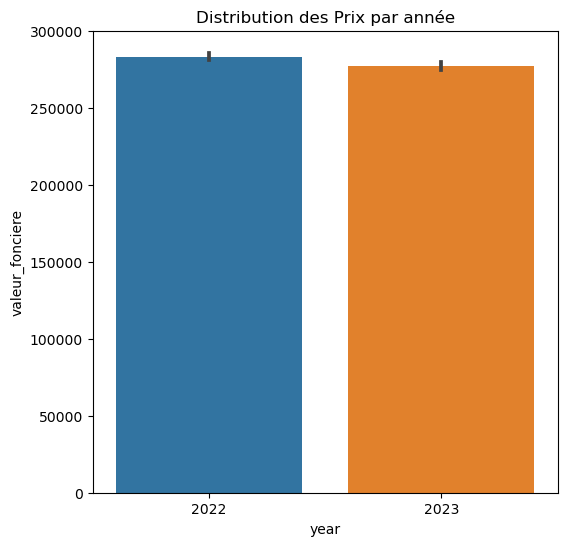

In [295]:
plt.figure(figsize=(6, 6))
sns.barplot(data = df_house_cleaned,y='valeur_fonciere', x='year')
plt.title('Distribution des Prix par année')

plt.show()

In [297]:
df_house[df_house['year']==2022]['valeur_fonciere'].mean()

283381.5628996245

In [299]:
df_house[df_house['year']==2023]['valeur_fonciere'].mean()

277183.758533215

In [301]:
import scipy.stats as stats

In [303]:
X1 = df_house[df_house['year']==2022]['valeur_fonciere']

In [305]:
X2 = df_house[df_house['year']==2023]['valeur_fonciere']

In [307]:
stats.ttest_ind(X1,X2)

TtestResult(statistic=3.237582284116471, pvalue=0.001207653215369019, df=18008.0)

### Correlation

In [610]:
df_house_cleaned.corr(numeric_only = True)['valeur_fonciere'].sort_values()

year                        -0.024183
code_postal                  0.036917
surface_terrain              0.155113
nombre_pieces_principales    0.426637
surface_reelle_bati          0.490900
prix_mcarre                  0.726744
valeur_fonciere              1.000000
Name: valeur_fonciere, dtype: float64

In [612]:
corr = df_house_cleaned.corr(numeric_only = True)
corr.style.background_gradient(cmap='coolwarm')

,valeur_fonciere,code_postal,surface_reelle_bati,nombre_pieces_principales,surface_terrain,year,prix_mcarre
valeur_fonciere,1.000000,0.036917,0.490900,0.426637,0.155113,-0.024183,0.726744
code_postal,0.036917,1.000000,0.031746,0.042090,0.046786,-0.002347,0.015249
surface_reelle_bati,0.490900,0.031746,1.000000,0.662014,0.282444,-0.025540,-0.168815
nombre_pieces_principales,0.426637,0.042090,0.662014,1.000000,0.133117,-0.028902,-0.005893
surface_terrain,0.155113,0.046786,0.282444,0.133117,1.000000,-0.008438,-0.038926
year,-0.024183,-0.002347,-0.025540,-0.028902,-0.008438,1.000000,-0.005975
prix_mcarre,0.726744,0.015249,-0.168815,-0.005893,-0.038926,-0.005975,1.000000


### Filtering by postal code

In [614]:
df_house_cleaned['code_postal'].value_counts()

code_postal
31600    872
31700    612
31470    610
31100    572
31140    553
        ... 
31280     66
31850     65
31580     54
31670     34
31000     27
Name: count, Length: 70, dtype: int64

In [616]:
#ex:
df_house_31600 = df_house_cleaned[df_house_cleaned['code_postal'] == 31600]

In [618]:
stats.linregress(df_house_31600['valeur_fonciere'],df_house_31600['surface_reelle_bati'])

LinregressResult(slope=0.0002030362037242239, intercept=48.53513591984489, rvalue=0.6372385638276268, pvalue=1.5882437640590698e-100, stderr=8.324886999641236e-06, intercept_stderr=2.4439730020174557)

<Axes: xlabel='valeur_fonciere', ylabel='surface_reelle_bati'>

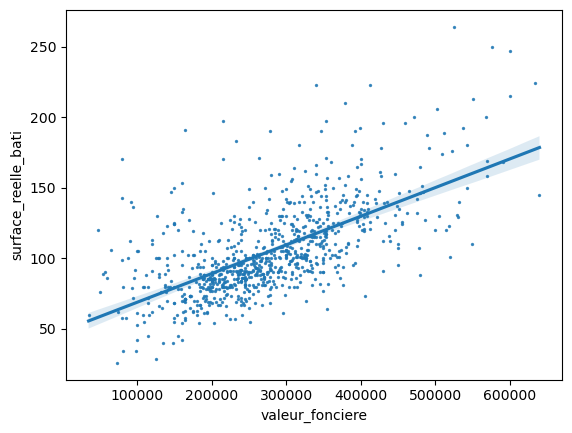

In [620]:
sns.regplot(x=df_house_31600['valeur_fonciere'], y=df_house_31600['surface_reelle_bati'],scatter_kws={'s':2})

In [357]:
len(df_house_cleaned['code_postal'].value_counts())

70

In [337]:
def calculate_correlation(group):
    return group['valeur_fonciere'].corr(group['surface_reelle_bati'])

In [622]:
correlation_by_postal_code = df_house.groupby('code_postal').apply(calculate_correlation)

count_above_05 = (correlation_by_postal_code > 0.5).sum()
count_above_05

44

In [624]:
count_below_or_equal_05 = (correlation_by_postal_code <= 0.5).sum()
count_below_or_equal_05

26

## Feature Engeneering

In [367]:
df_house_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   valeur_fonciere            17973 non-null  float64
 1   code_postal                17973 non-null  int64  
 2   nom_commune                17973 non-null  object 
 3   type_local                 17973 non-null  object 
 4   surface_reelle_bati        17973 non-null  float64
 5   nombre_pieces_principales  17973 non-null  float64
 6   nature_culture             16488 non-null  object 
 7   surface_terrain            17973 non-null  float64
 8   year                       17973 non-null  int64  
 9   prix_mcarre                17973 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.4+ MB


In [370]:
# Type colonne object (categorie): Year,Codepostale, 
df_house_cleaned['code_postal'] = df_house_cleaned['code_postal'].apply(str)
df_house_cleaned['year'] = df_house_cleaned['year'].apply(str)

In [372]:
df_house_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   valeur_fonciere            17973 non-null  float64
 1   code_postal                17973 non-null  object 
 2   nom_commune                17973 non-null  object 
 3   type_local                 17973 non-null  object 
 4   surface_reelle_bati        17973 non-null  float64
 5   nombre_pieces_principales  17973 non-null  float64
 6   nature_culture             16488 non-null  object 
 7   surface_terrain            17973 non-null  float64
 8   year                       17973 non-null  object 
 9   prix_mcarre                17973 non-null  float64
dtypes: float64(5), object(5)
memory usage: 1.4+ MB


In [ ]:
# ou l'entrainer sur log ou sur valeur fonciere clean : suppr metre carré/ +log ou valeur fonciere (tester les 2 ?)/ supprimer month ?

In [374]:
df_ml = df_house_cleaned[['valeur_fonciere','code_postal','surface_reelle_bati','nombre_pieces_principales','nature_culture','surface_terrain']]

In [376]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   valeur_fonciere            17973 non-null  float64
 1   code_postal                17973 non-null  object 
 2   surface_reelle_bati        17973 non-null  float64
 3   nombre_pieces_principales  17973 non-null  float64
 4   nature_culture             16488 non-null  object 
 5   surface_terrain            17973 non-null  float64
dtypes: float64(4), object(2)
memory usage: 842.6+ KB


In [ ]:
#dummies categorie (codepostale, year, ...)

In [392]:
my_object_df = df_ml.select_dtypes(include='object')

In [394]:
my_numeric_df = df_ml.select_dtypes(exclude='object')

In [396]:
df_objects_dummies = pd.get_dummies(my_object_df,drop_first=True)

In [398]:
df_objects_dummies

,code_postal_31100,code_postal_31110,code_postal_31120,code_postal_31130,code_postal_31140,code_postal_31150,code_postal_31160,code_postal_31170,code_postal_31180,code_postal_31190,...,nature_culture_landes,nature_culture_peupleraies,nature_culture_prés,nature_culture_sols,nature_culture_taillis simples,nature_culture_taillis sous futaie,nature_culture_terrains a bâtir,nature_culture_terrains d'agrément,nature_culture_terres,nature_culture_vignes
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
17969,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
17970,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
17971,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [400]:
final_df= pd.concat([my_numeric_df,df_objects_dummies],axis=1)

In [402]:
final_df

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,code_postal_31100,code_postal_31110,code_postal_31120,code_postal_31130,code_postal_31140,code_postal_31150,...,nature_culture_landes,nature_culture_peupleraies,nature_culture_prés,nature_culture_sols,nature_culture_taillis simples,nature_culture_taillis sous futaie,nature_culture_terrains a bâtir,nature_culture_terrains d'agrément,nature_culture_terres,nature_culture_vignes
0,315000.0,125.0,5.0,482.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,409670.0,160.0,4.0,1161.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,357350.0,158.0,6.0,1095.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,353300.0,114.0,5.0,862.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,500000.0,255.0,5.0,1200.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,140000.0,70.0,3.0,322.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
17969,70000.0,67.0,3.0,60.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
17970,240000.0,120.0,4.0,5345.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
17971,121720.0,78.0,3.0,488.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [405]:
final_df.to_csv('HousePricefinal_ML.csv',index=False)

## modele regression lineaire (ElastiqueNet puis Lasso ou autre...)

In [410]:
df = pd.read_csv('HousePricefinal_ML.csv')

In [412]:
df

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,code_postal_31100,code_postal_31110,code_postal_31120,code_postal_31130,code_postal_31140,code_postal_31150,...,nature_culture_landes,nature_culture_peupleraies,nature_culture_prés,nature_culture_sols,nature_culture_taillis simples,nature_culture_taillis sous futaie,nature_culture_terrains a bâtir,nature_culture_terrains d'agrément,nature_culture_terres,nature_culture_vignes
0,315000.0,125.0,5.0,482.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,409670.0,160.0,4.0,1161.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,357350.0,158.0,6.0,1095.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,353300.0,114.0,5.0,862.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,500000.0,255.0,5.0,1200.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,140000.0,70.0,3.0,322.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
17969,70000.0,67.0,3.0,60.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
17970,240000.0,120.0,4.0,5345.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
17971,121720.0,78.0,3.0,488.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


### Creation X et y

In [416]:
X= df.drop('valeur_fonciere',axis=1)
y=df['valeur_fonciere']

### Train Test split

In [428]:
from sklearn.model_selection import train_test_split

In [430]:
#Test 10%,  random : 101
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

### Mise a l'echelle

In [438]:
from sklearn.preprocessing import StandardScaler

In [440]:
scaler = StandardScaler()

In [442]:
scaler.fit(X_train)

StandardScaler()

In [444]:
X_train = scaler.transform(X_train)

In [446]:
X_test = scaler.transform(X_test)

### Modele RL : ElasticNet

In [457]:
from sklearn.linear_model import ElasticNet

In [459]:
model = ElasticNet(max_iter=100000)

In [461]:
from sklearn.model_selection import GridSearchCV

In [463]:
param_grid = {'alpha':[0.1,1.5,10,50,100],'l1_ratio':[0.1,0.5,0.7,0.9,0.95,0.99,1]}

In [465]:
grid_model = GridSearchCV(estimator=model,param_grid=param_grid,scoring='neg_mean_squared_error',cv=5,verbose=1)

In [467]:
grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000),
             param_grid={'alpha': [0.1, 1.5, 10, 50, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [468]:
grid_model.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=1, max_iter=100000)

In [479]:
y_pred = grid_model.predict(X_test)

In [482]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [485]:
RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
RMSE

84224.13007517044

In [488]:
MAE = mean_absolute_error(y_test,y_pred)
MAE

62379.65974063133

In [491]:
np.mean(df.valeur_fonciere)

280446.36277916876

In [511]:
# Distribution des erreurs
errors = y_pred - y_test

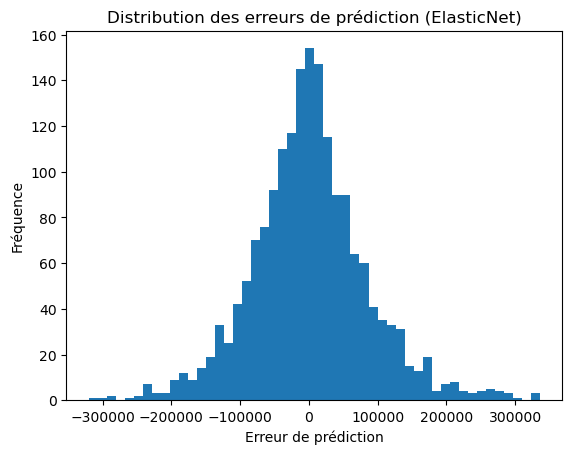

In [513]:
plt.hist(errors, bins=50)
plt.xlabel('Erreur de prédiction')
plt.ylabel('Fréquence')
plt.title('Distribution des erreurs de prédiction (ElasticNet)')
plt.show()

### Model RL : Lasso

In [475]:
from sklearn.linear_model import LassoCV

In [495]:
lasso_model = LassoCV(eps=0.1,n_alphas=100,cv=5)

In [497]:
lasso_model.fit(X_train,y_train)

LassoCV(cv=5, eps=0.1)

In [499]:
lasso_model.alpha_

6203.587441386862

In [501]:
test_prediction=lasso_model.predict(X_test)

In [503]:
RMSE = np.sqrt(mean_squared_error(y_test,test_prediction))
RMSE

93972.39661135056

In [505]:
MAE = mean_absolute_error(y_test,test_prediction)
MAE

71858.48979071276

In [509]:
lasso_model.coef_

array([ 46447.89640887,  13174.94584387,   3042.20440965,      0.        ,
         -613.00363761,      0.        ,   6235.64700678,      0.        ,
            0.        , -11149.30612452,   5869.70828342,   1393.91043963,
         -315.00426644,   6660.13217924,  -9096.29266193,  -7413.76962198,
        -6150.6296293 ,   3043.30521847,  -3656.67835162,  -8380.12663872,
            0.        ,      0.        ,     -0.        ,    687.60240922,
        -5413.66238185,   3900.45228378,     -0.        ,     -0.        ,
        -5907.4999322 ,  -4556.99310821,     -0.        ,      0.        ,
           -0.        ,   7646.13928764,     -0.        ,  -4894.37540124,
        -1556.66494497,  -6765.38524986,      0.        ,     -0.        ,
            0.        ,     -0.        ,      0.        ,  10182.52152567,
        -6129.2529361 ,    724.058178  ,     -0.        ,   -483.42362525,
         -113.91157571,   -384.21754541,      0.        ,  -2077.12359306,
            0.        ,  

## Model Random Forest

In [518]:
from sklearn.ensemble import RandomForestRegressor

In [520]:
rf = RandomForestRegressor(random_state=42)

In [522]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [524]:
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [526]:
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [532]:
best_rf = grid_search_rf.best_estimator_

In [534]:
rf_predictions = best_rf.predict(X_test)

In [536]:
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_predictions))
rmse_rf

82563.55576522804

In [538]:
mae_rf = mean_absolute_error(y_test, rf_predictions)
mae_rf

60934.787374488056

## Logarythmique distribution

In [ ]:
df= pd.read_csv('log_house_price.csv')

In [ ]:
df.info

In [ ]:
df = df[['','','','','','','']]